**Fraud Analytics Assignment**  
**Title: Fraud Detection Using an Autoencoder and Variational Autoencoder**  
---
**Group members:**  
**Name&emsp;: Dindorkar Mayuresh Rajesh**  
**Roll No&nbsp;: CS23MTECH14007**  

**Name&emsp;: Sanyam Kaul**  
**Roll No&nbsp;: CS23MTECH14011**  

**Name&emsp;: Shrenik Ganguli**  
**Roll No&nbsp;: CS23MTECH14014**  

**Name&emsp;: Morey Piyush Prabhakar**  
**Roll No&nbsp;: AI23MTECH14003**  

---

**Importing the libraries:**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (recall_score, precision_recall_curve, roc_curve, classification_report, auc, f1_score, confusion_matrix, 
precision_recall_fscore_support)
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable

**Using GPU if available:**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Class:**  
Transactions with label 0 denotes 'Normal transaction'  
Transactions with label 1 denotes 'Fraud transaction'

In [3]:
idx_to_label_dict = {
    0: "Normal Transaction",
    1: "Fraud Transaction"
}

**Utility functions used:**

In [4]:
def plot_epoch_vs_loss(epochs, loss, title):
  plt.plot(epochs, loss)
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.title(title)
  plt.show()

In [5]:
def train_autoencoder_model(autoencoder, epochs, train_loader, loss_function, optimizer):
    epoch_loss_list = []
    autoencoder.train()
    for epoch in range(epochs):
        all_batches_loss = 0
        for batch, batch_data in enumerate(train_loader):
            batch_data = batch_data.to(device)

            optimizer.zero_grad()
            outputs = autoencoder(batch_data)
            loss = loss_function(outputs, batch_data)

            loss.backward()
            optimizer.step()
            all_batches_loss = all_batches_loss + loss.item()

        epoch_loss_list.append(all_batches_loss / len(train_loader))
        print(f'Epoch {epoch+1}, Loss: {epoch_loss_list[-1]}')
    return epoch_loss_list

In [6]:
def train_VAE(vae, optimizer, epochs, train_loader, vae_loss_function):
    epoch_loss_list = []
    vae.train()
    for epoch in range(epochs):
        all_batches_loss = 0
        for batch_idx, x in enumerate(train_loader):
            x = x.to(device)
            optimizer.zero_grad()

            x_hat, mean, log_var = vae(x)

            loss = vae_loss_function(x, x_hat, mean, log_var)
            loss.backward()
            optimizer.step()
            all_batches_loss = all_batches_loss + loss.item()

        epoch_loss_list.append(all_batches_loss / len(train_loader))
        print(f'Epoch {epoch+1}, Loss: {epoch_loss_list[-1]}')
    return epoch_loss_list

In [7]:
class Custom_Dataset(Dataset):
    def __init__(self, tensor):
        self.tensor = tensor

    def __getitem__(self, idx):
        return self.tensor[idx]

    def __len__(self):
        return len(self.tensor)

In [8]:
def evaluate_model(model, test_tensor, model_type, test_set = None):
    model.eval()
    error_df = None
    mse = None
    test_tensor = test_tensor.to(device)
    with torch.no_grad():
      if model_type == 'VAE':
        (pred, _, _) = model(test_tensor)
      else:
        pred = model(test_tensor)
      mse = torch.mean(torch.pow(test_tensor - pred, 2), dim=1)
      if test_set is not None:
        error_df = pd.DataFrame({'regeneration_error': mse.cpu(), 'true_label': test_set.iloc[:,-1]})
    return mse, error_df

In [9]:
def plot_scatter_graph(threshold, error_df):
    colors = ['green', 'red']
    fig, ax = plt.subplots(figsize=(14, 10))
    groups = error_df.groupby('true_label')
    [ax.plot(group.index, group.regeneration_error, marker='o', ms=3.5, linestyle='',
         label="Fraud" if name == 1 else "Normal", color=color)
    for color, (name, group) in zip(colors, groups)]
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1],  zorder=100, colors="blue", label='Threshold value')
    plt.title("Regeneration error for Normal and Fraud transactions")
    plt.xlabel("Credit card transactions")
    plt.ylabel("Regeneration error")
    ax.legend()
    plt.show()

In [10]:
def plot_confusion_matrix(title, cm, labels):
    plt.figure(figsize=(7, 7))
    sns.heatmap(cm, annot=True, xticklabels = labels, fmt="d", yticklabels = labels, cmap='Blues')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.title(title)
    plt.show()

In [11]:
def plot_ROC_Curve(err_df, title):
    x_limit = [-0.001, 1]
    y_limit = [0, 1.001]
    fp_rate, tp_rate, thresholds = roc_curve(err_df.true_label, err_df.regeneration_error)
    roc_auc = auc(fp_rate, tp_rate)
    plt.title(title)
    plt.plot(fp_rate, tp_rate, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.xlim(x_limit)
    plt.ylim(y_limit)
    plt.xlabel('FPR (False Positive Rate)')
    plt.ylabel('TPR (True Positive Rate)')
    plt.legend()
    plt.show()

---

**Reading the dataset csv file (dataset):**

In [12]:
df = pd.read_csv('creditcard.csv')
df.shape

(284807, 31)

In [13]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**Checking for NULL values in dataset:**

In [14]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

**Counting the population of each class label:**  



Class label: Normal Transaction , Count: 284315
Class label: Fraud Transaction , Count: 492


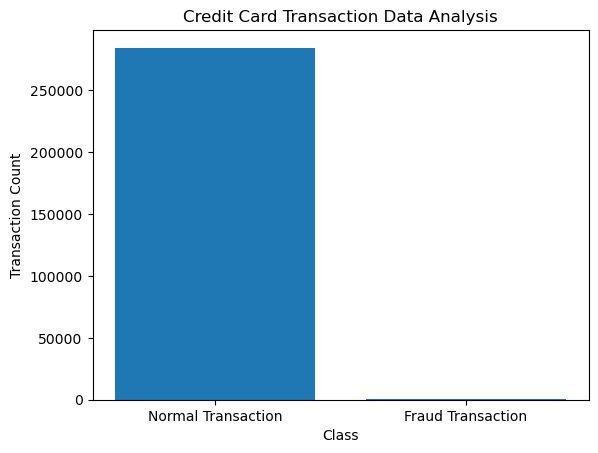

In [15]:
classwise_population = df['Class'].value_counts()
for class_idx, count in classwise_population.items():
    print('Class label:', idx_to_label_dict[class_idx], ', Count:', count)
plt.bar(idx_to_label_dict.values(), classwise_population.values)
plt.title("Credit Card Transaction Data Analysis")
plt.ylabel("Transaction Count")
plt.xlabel("Class")
plt.xticks(np.arange(2))
plt.show()

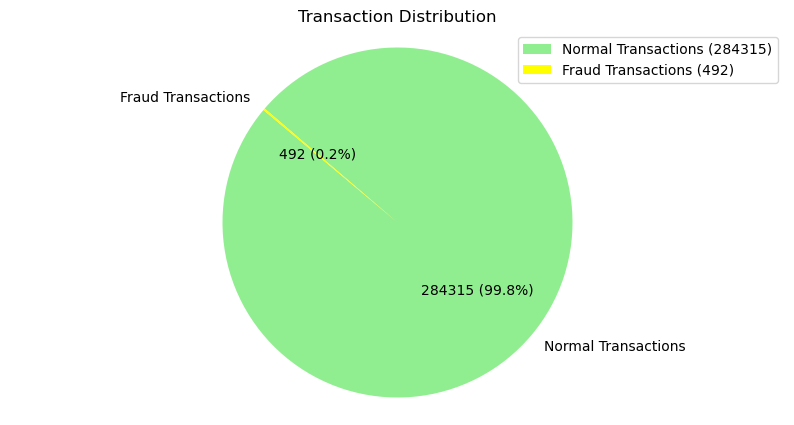

In [16]:
# Plotting pie chart
counts = [284315, 492]
colors = ['lightgreen', 'yellow']
labels =['Normal Transactions', 'Fraud Transactions']
plt.figure(figsize=(10, 5))
plt.pie(counts, labels=labels, colors=colors, autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * sum(counts) / 100, p),
        startangle=140)
plt.title('Transaction Distribution')
plt.legend(loc='upper right', labels=[f'{label} ({count})' for label, count in zip(labels, counts)], fontsize='medium')

plt.axis('equal')
plt.show()

**Feature Engineering: (Feature Selection)**

In [17]:
# Dropping the 'Time' comlumn
df.drop(['Time'], axis=1, inplace=True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


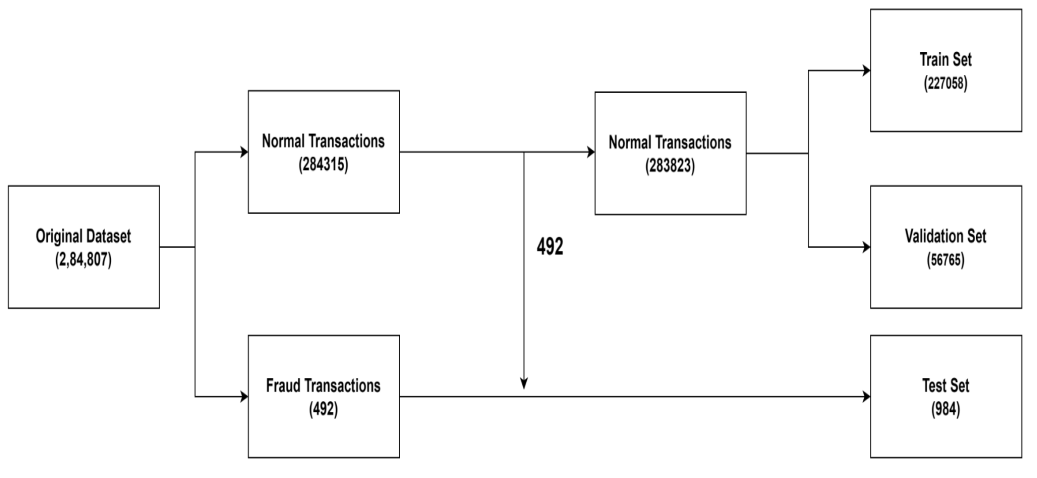

**Segregating the dataset into Normal and Fraud transacitions:**

In [18]:
normal_df = df[df.Class == 0]
fraud_df = df[df.Class == 1]
print(f'Number of Normal transactions: {len(normal_df)}')
print(f'Number of Fraud transactions: {len(fraud_df)}')

Number of Normal transactions: 284315
Number of Fraud transactions: 492


**Creating the Test set:**

In [19]:
# Randomly sample 492 samples from Normal transactions
normal_test_df = normal_df.sample(n=492, random_state=42, replace=True)
normal_df = normal_df.drop(normal_test_df.index)

# Creating the Test set by concatenating the 492 Normal and 492 Fraud samples
test_set = pd.concat([normal_test_df, fraud_df], axis=0)
print(f'Number of transactions in Test dataset: {len(test_set)}')

Number of transactions in Test dataset: 984


In [20]:
normal_df.drop('Class', axis=1, inplace=True)
normal_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


**Normalizing the dataset features:**

In [21]:
mm = MinMaxScaler()
normal_df = mm.fit_transform(normal_df)

class_column_test = test_set.iloc[:, [-1]]
test_set.iloc[:,:-1] = mm.transform(test_set.iloc[:,:-1])
test_set['Class'] = class_column_test

**Creating the Train and Validation set:**

In [22]:
X_train, X_val = train_test_split(normal_df, test_size=0.2, random_state=42)
print(f'Number of transactions in Training set : {X_train.shape}')
print(f'Number of transactions in Validation set : {X_val.shape}')

Number of transactions in Training set : (227058, 29)
Number of transactions in Validation set : (56765, 29)


---

**Converting dataframe into tensors:**

In [23]:
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)

print(f'Shape of train set : {X_train_tensor.shape}')
print(f'Shape of validation set : {X_val_tensor.shape}')

Shape of train set : torch.Size([227058, 29])
Shape of validation set : torch.Size([56765, 29])


In [24]:
# Creating data loaders
batch_size = 100
train_loader = DataLoader(Custom_Dataset(X_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(Custom_Dataset(X_val_tensor), batch_size=batch_size, shuffle=False)

---

**Autoencoder (AE):**

In [25]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder, self).__init__()
        self.initialize_attributes(input_dim = input_dim, latent_dim = latent_dim)
        
        # Encoder block
        self.encoder_block = nn.Sequential(
            nn.Linear(self.input_dim, 22),
            nn.Tanh(),
            nn.Linear(22, 15),
            nn.ReLU(),
            nn.Linear(15, self.latent_dim)
        )

        # Decoder block
        self.decoder_block = nn.Sequential(
            nn.Linear(self.latent_dim, 15),
            nn.ReLU(),
            nn.Linear(15, 22),
            nn.Tanh(),
            nn.Linear(22, self.input_dim),
        )
    
    def initialize_attributes(self, input_dim, latent_dim):
        self.latent_dim = latent_dim
        self.input_dim = input_dim

    def forward(self, x):
        return self.decoder_block(self.encoder_block(x))

**Model Initialization:**

In [39]:
autoencoder = AutoEncoder(input_dim = X_train_tensor.shape[1], latent_dim = 8).to(device)
print(autoencoder)

AutoEncoder(
  (encoder_block): Sequential(
    (0): Linear(in_features=29, out_features=22, bias=True)
    (1): Tanh()
    (2): Linear(in_features=22, out_features=15, bias=True)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=8, bias=True)
  )
  (decoder_block): Sequential(
    (0): Linear(in_features=8, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=22, bias=True)
    (3): Tanh()
    (4): Linear(in_features=22, out_features=29, bias=True)
  )
)


**Training the Autoencoder:**

Epoch 1, Loss: 0.0060114040726796615
Epoch 2, Loss: 0.0014454525412941613
Epoch 3, Loss: 0.001010816900204344
Epoch 4, Loss: 0.0007563189636503368
Epoch 5, Loss: 0.0005560815074295093
Epoch 6, Loss: 0.0004902850236215283
Epoch 7, Loss: 0.00040266399420137573
Epoch 8, Loss: 0.00038127544662711765
Epoch 9, Loss: 0.00037233411746317145
Epoch 10, Loss: 0.0003564318458618677


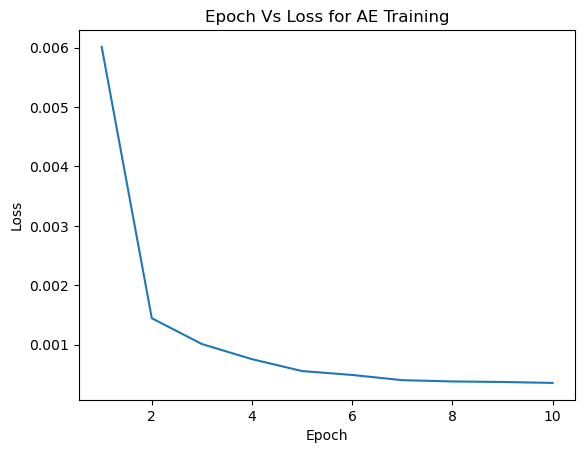

In [40]:
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
epochs = 10
epoch_loss_list = train_autoencoder_model(autoencoder = autoencoder, train_loader = train_loader, optimizer = optimizer,
                                          loss_function = nn.MSELoss(), epochs = epochs)
plot_epoch_vs_loss(np.arange(1, epochs + 1), epoch_loss_list, title = "Epoch Vs Loss for AE Training")

**Checking performance of AE on Validation set:**

In [41]:
val_mse, _ = evaluate_model(model = autoencoder, test_tensor = X_val_tensor, model_type = 'AE')
print(f'Mean Square Error on Validation Set: {sum(val_mse) / len(val_mse)}')

Mean Square Error on Validation Set: 0.0003555213625077158


**Performance of AE on Test set:**

In [42]:
X_test_tensor = torch.FloatTensor(test_set.iloc[:, :-1].to_numpy())
test_mse, err_df = evaluate_model(model = autoencoder, test_tensor = X_test_tensor, test_set = test_set, model_type = 'AE')
print(f'Mean Square Error on Test Set: {sum(test_mse) / len(test_mse)}')

Mean Square Error on Test Set: 0.0030974424444139004


**Deciding the threshold:**

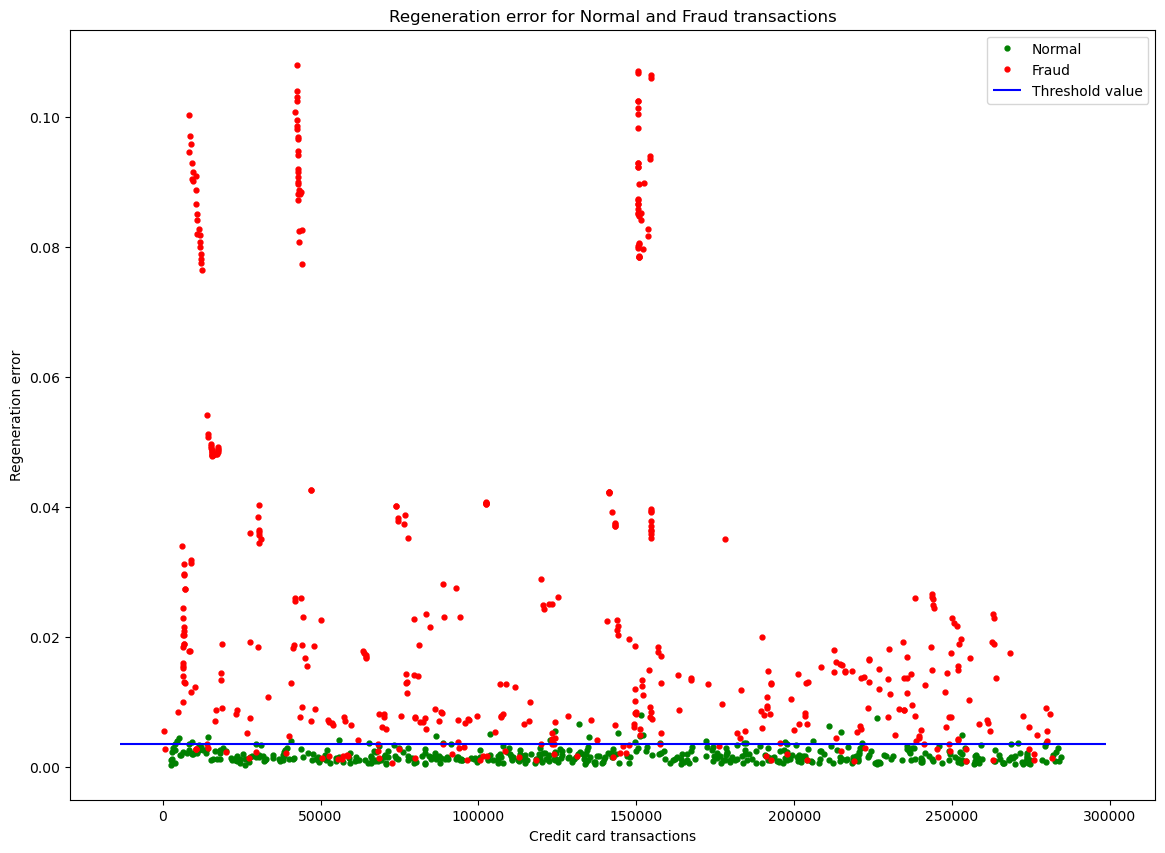

In [72]:
threshold = 0.0036
plot_scatter_graph(threshold = threshold, error_df = err_df)

**Confusion Matrix for Autoencoder results:**

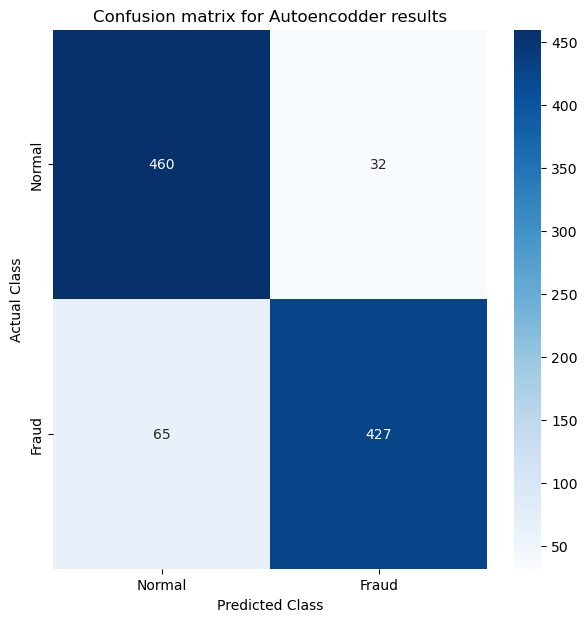

In [73]:
# Assigning labels to test samples based on threshold
y_pred_autoencoder = np.where(err_df.regeneration_error.values >= threshold, 1, 0)

# Plotting the confusion matrix
cm = confusion_matrix(err_df.true_label, y_pred_autoencoder)
plot_confusion_matrix(title = "Confusion matrix for Autoencodder results", labels = ["Normal", "Fraud"], cm = cm)

**Plotting ROC Curve for AE results:**

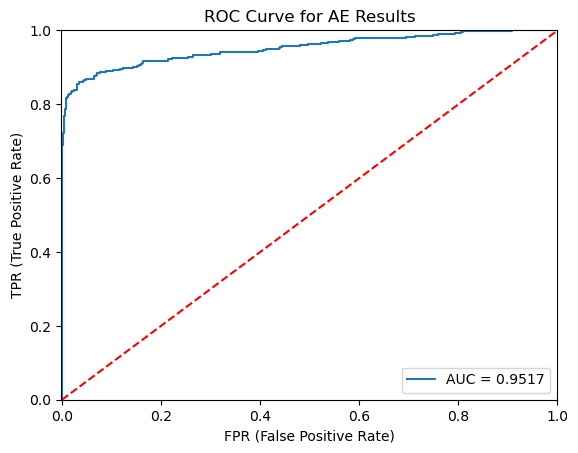

In [74]:
plot_ROC_Curve(err_df, title = 'ROC Curve for AE Results')

**Classification Report for AE results:**

In [75]:
report = classification_report(err_df.true_label, y_pred_autoencoder)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       492
           1       0.93      0.87      0.90       492

    accuracy                           0.90       984
   macro avg       0.90      0.90      0.90       984
weighted avg       0.90      0.90      0.90       984



---  
**Variational Autoencoder (VAE):**

In [47]:
class Variational_AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Variational_AutoEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.z_mean = nn.Linear(15, self.latent_dim)
        self.z_log_of_var = nn.Linear(15, self.latent_dim)
        self.input_dim = input_dim

        # Encoder block
        self.encoder_block = nn.Sequential(
            nn.Linear(self.input_dim, 22),
            nn.Tanh(),
            nn.Linear(22, 15),
            nn.ReLU()
        )

        # Decoder block
        self.decoder_block = nn.Sequential(
            nn.Linear(self.latent_dim, 15),
            nn.ReLU(),
            nn.Linear(15, 22),
            nn.Tanh(),
            nn.Linear(22, self.input_dim)
        )

    def sample_from_normal_distribution(self, mean, latent_dim):
        # torch.randn: Samples from Normal distribution with given mean and std = 1
        return torch.randn(mean, latent_dim)

    def sample_z_value(self, epsilon = None):
        if epsilon is None:
            epsilon = self.sample_from_normal_distribution(self.mean.size(0), self.latent_dim)
        epsilon = epsilon.to(device)
        return self.mean + torch.exp(0.5 * self.log_of_var) * epsilon

    def forward(self, inputs):
        # Encode
        encoder_output = self.encoder_block(inputs)
        self.mean = self.z_mean(encoder_output)
        self.log_of_var = self.z_log_of_var(encoder_output)

        # Sample z from latent space using mean and std
        z = self.sample_z_value().to(device)

        # Decode
        return self.decoder_block(z), self.mean, self.log_of_var

# KL divergence loss
def calculate_KL_divergence_loss(mean, log_of_var):
    return -0.5 * torch.sum(1 + log_of_var - mean.pow(2) - log_of_var.exp(), dim=-1)

# VAE loss function
def VAE_loss_function(y_true, y_pred, z_mean, z_log_var):
    return nn.MSELoss()(y_pred, y_true) + torch.mean(calculate_KL_divergence_loss(z_mean, z_log_var))

**Model Initialization:**

In [48]:
vae = Variational_AutoEncoder(input_dim = X_train_tensor.shape[1], latent_dim = 8).to(device)
print(vae)

Variational_AutoEncoder(
  (z_mean): Linear(in_features=15, out_features=8, bias=True)
  (z_log_of_var): Linear(in_features=15, out_features=8, bias=True)
  (encoder_block): Sequential(
    (0): Linear(in_features=29, out_features=22, bias=True)
    (1): Tanh()
    (2): Linear(in_features=22, out_features=15, bias=True)
    (3): ReLU()
  )
  (decoder_block): Sequential(
    (0): Linear(in_features=8, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=22, bias=True)
    (3): Tanh()
    (4): Linear(in_features=22, out_features=29, bias=True)
  )
)


**Training the VAE:**

Epoch 1, Loss: 0.009159310645813828
Epoch 2, Loss: 0.0019162877886020916
Epoch 3, Loss: 0.0019102267485143938
Epoch 4, Loss: 0.0019092655796861134
Epoch 5, Loss: 0.0019073854096993339
Epoch 6, Loss: 0.0019062567342426227
Epoch 7, Loss: 0.0019050152848902409
Epoch 8, Loss: 0.0019041663161854171
Epoch 9, Loss: 0.0019035205735182385
Epoch 10, Loss: 0.0019026481010674288


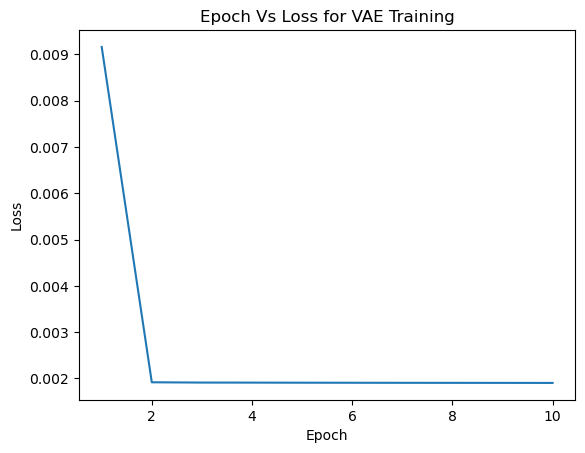

In [49]:
epochs = 10
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
epoch_loss_list = train_VAE(vae = vae, optimizer = optimizer, train_loader = train_loader, vae_loss_function = VAE_loss_function, epochs = epochs)
plot_epoch_vs_loss(np.arange(1, epochs + 1), epoch_loss_list, title = "Epoch Vs Loss for VAE Training")

**Performance of VAE on Validation set:**

In [50]:
val_mse, _ = evaluate_model(model = vae, test_tensor = X_val_tensor, model_type = 'VAE')
print(f'Mean Square Error on Validation Set: {sum(val_mse) / len(val_mse)}')

Mean Square Error on Validation Set: 0.0019029646646231413


**Performance of VAE on Test set:**

In [51]:
X_test_tensor = torch.FloatTensor(test_set.iloc[:, :-1].to_numpy())
test_mse, err_df = evaluate_model(model = vae, test_tensor = X_test_tensor, test_set = test_set, model_type = 'VAE')
print(f'Mean Square Error on Test Set: {sum(test_mse) / len(test_mse)}')

Mean Square Error on Test Set: 0.015335763804614544


**Deciding the threshold:**

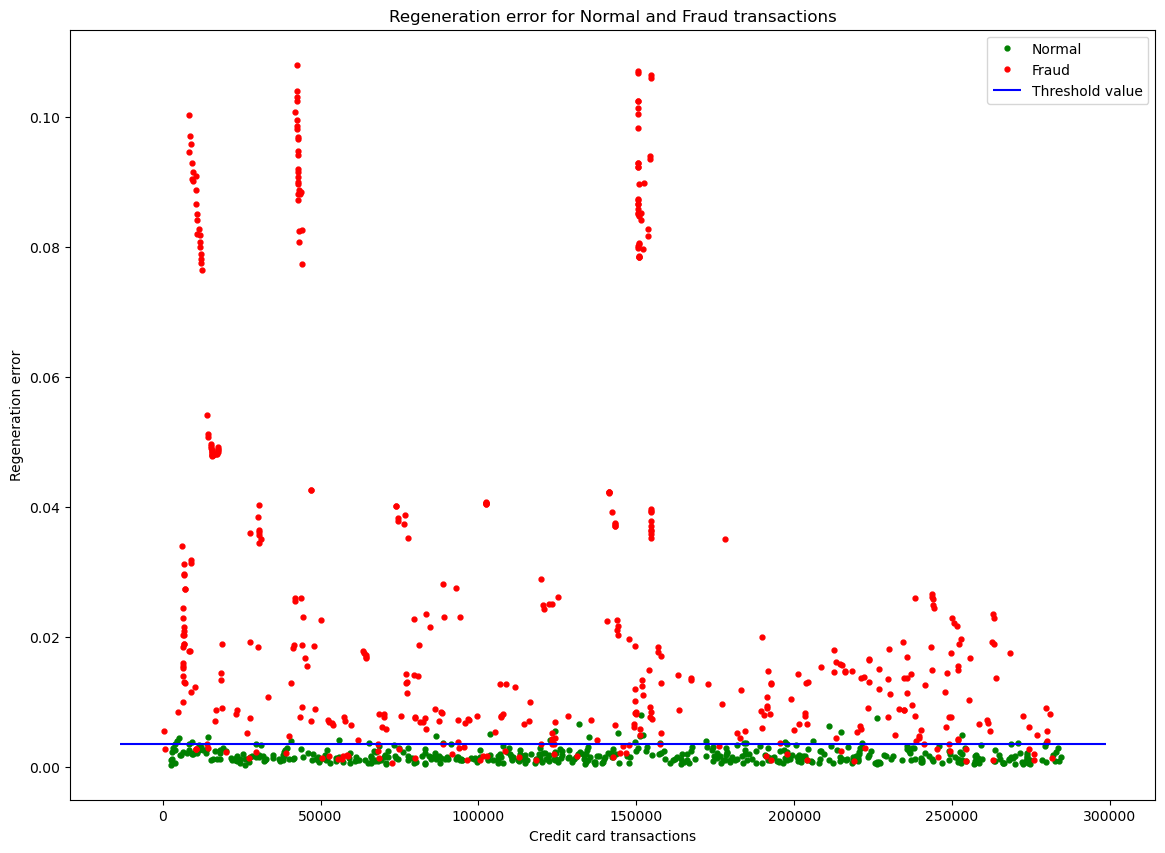

In [68]:
# scatter plot
threshold = 0.0036
plot_scatter_graph(threshold = threshold, error_df = err_df)

**Confusion Matrix for VAE results:**

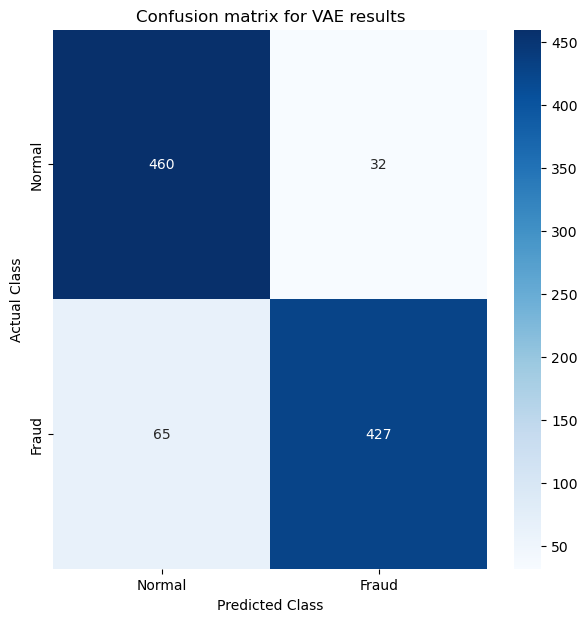

In [69]:
# Assigning labels to test samples based on threshold
y_pred_vae = np.where(err_df.regeneration_error.values >= threshold, 1, 0)

# Plotting the confusion matrix
cm = confusion_matrix(err_df.true_label, y_pred_vae)
plot_confusion_matrix(title = "Confusion matrix for VAE results", labels = ["Normal", "Fraud"], cm = cm)

**Plotting ROC Curve for VAE results:**

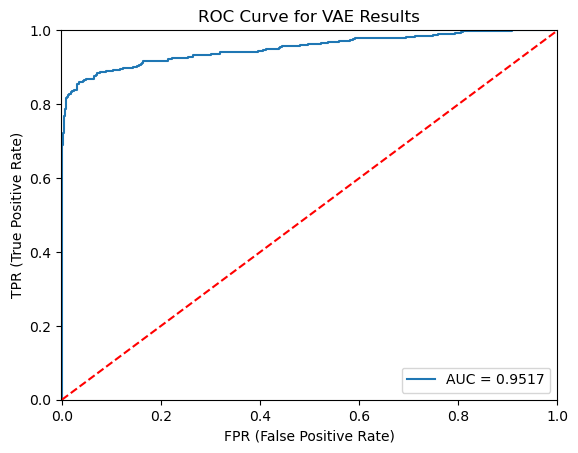

In [70]:
plot_ROC_Curve(err_df, title = 'ROC Curve for VAE Results')

**Classification Report for VAE results:**

In [71]:
print(classification_report(err_df.true_label, y_pred_autoencoder))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       492
           1       0.94      0.86      0.90       492

    accuracy                           0.90       984
   macro avg       0.91      0.90      0.90       984
weighted avg       0.91      0.90      0.90       984



**Results:**  
- We can see from the observations that the optimal selection of threshold for VAE can out-perform Autoencoder.
- For same value of threshold, VAE has given slight better F1-Score for both classes compared to AE.   
- Through VAE we have learnt the probabilistic distribution of our data, which can be utilized for synthetic data generation.
| Model | F1-Score for Class '0' on Test set | F1-Score for Class '1' on Test set |
| ----- | ---------------------------- | ---------------------------- |
| AE    | 0.90                         | 0.90                         |
| VAE   | 0.91                         | 0.90                         ||

---